### Imports

In [99]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import trange
from glob import glob
from PIL import Image
from skimage.util import img_as_float, img_as_ubyte
from skimage.feature import canny
from skimage import io, transform
from skimage.morphology import thin
from skimage.filters import gaussian
from skimage.registration import phase_cross_correlation
from tensorflow.python.client import device_lib
from scipy.signal import find_peaks
from scipy.spatial.transform import Rotation as R
from scipy.ndimage import distance_transform_edt, binary_fill_holes, binary_closing
from common import *

### Typical optical image of a silicon wafer

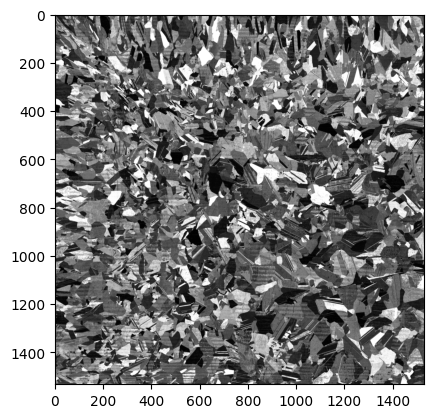

In [13]:
# name of the image refers to the Φ angle of our homemade device
optical_image = io.imread("data_collection/optical_images/60/000.png")
fig, ax = plt.subplots()
ax.imshow(optical_image)
plt.gray();

### Grain boundary extraction

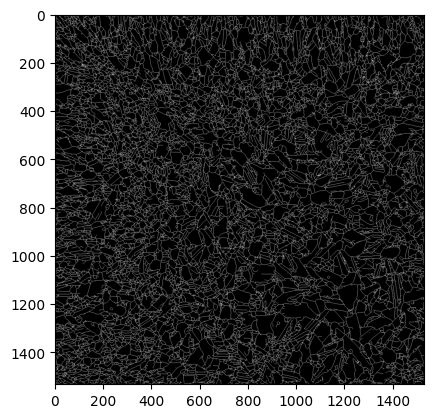

In [61]:
path = "data_collection/optical_images/60"
files = os.listdir(path)
images = np.array([img_as_float(io.imread(f"{path}/{file}")) for file in files])[:, :, :]
_, h, w = images.shape

sigma = 4
img_canny = np.zeros((h,w), dtype=bool)
for img in images:
    img_canny += canny(img, sigma=sigma)
img_canny = thin(img_canny)

fig, ax = plt.subplots()
ax.imshow(img_canny)
plt.gray();
io.imsave("results_for_articles/grain_boundary_extraction.png", img_as_ubyte(img_canny))

### Crystal grain segmentation

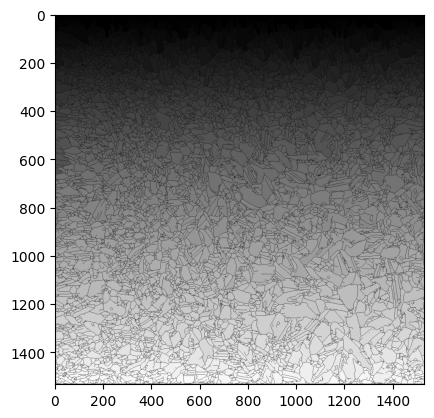

In [117]:
img_canny = cv2.imread("results_for_articles/grain_boundary_extraction.png", cv2.COLOR_BGR2GRAY)
img_canny = segmentation(img_canny)

img_label = img_canny

plt.imshow(img_canny)
plt.show()

io.imsave("results_for_articles/grain_segmentation.tif", img_canny)

### Crystal orientation estimation
#### For more details please refer to our paper "A machine learning-based prediction of crystal orientations for multicrystalline materials"

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 144)               85248     
                                                                 
 dense (Dense)               (None, 128)               18560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 4)                 516       
                                                                 
 activation (Activation)     (None, 4)                 0

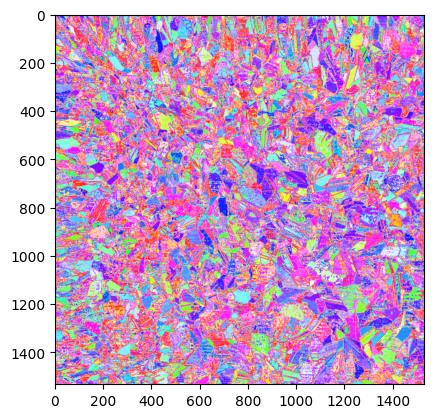

In [91]:
path_model = "data_collection"
parent_data = "data_collection/optical_images/"
model = tf.keras.models.load_model(f'{path_model}/model',
                                   compile=False, custom_objects={})

model.summary()

images = np.array([[gaussian(np.array(Image.open(file))/200,1) for file in glob(f'{parent_data}60/*')],
                   [gaussian(np.array(Image.open(file))/200,1) for file in glob(f'{parent_data}45/*')],
                   [gaussian(np.array(Image.open(file))/200,1) for file in glob(f'{parent_data}30/*')]]) # shape = (3, 72, 1733, 1733)

np.save("results_for_articles/luminence.npy", images)

_, _ , h, w = images.shape
images = images.transpose(2,3,1,0) # shape = (1533,1533,72,3)
q_images = model.predict(images.reshape(-1,72,3)).reshape(h,w,4)

np.save("results_for_articles/quaternion.npy", q_images)

rot = R.from_quat(q_images.reshape(-1, 4))
img_ND = get_RGB(stereographic2sst(rot.apply([0,0,1]))).reshape(h,w,3)
io.imsave("results_for_articles/IPF.tif", img_as_ubyte(img_ND))

fig, ax = plt.subplots()
ax.imshow(img_ND);

### Crystal orientation averaging

1533 1533 3


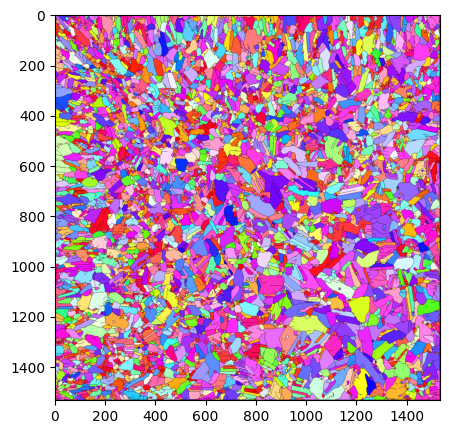

In [147]:
# Load quaternion results
q_images = np.load("results_for_articles/quaternion.npy")

# reshape 3dim to 2dim
x, y, Q = q_image.shape
reshaped_q_image = q_image.reshape((x * y, Q))

# make data fram for crystsal orientation averaging
df = pd.DataFrame(reshaped_q_image, columns=['q1', 'q2', 'q3', 'q4'])
df['x'] = np.tile(np.arange(x), y)
df['y'] = np.repeat(np.arange(y), x)

img_label = io.imread("results_for_articles/grain_segmentation.tif")
h, w = img_label.shape

img_label = img_label.reshape((h * w))
df['Grain ID'] = img_label # add Grain ID column which contains segmented grain labels, grain boundary is labeled as -1

# Delete rows that refers to grain boundary
df_drop = df.drop(df[df['Grain ID'] == -1].index)
df_drop

# Unique labels
unique_labels = np.unique(img_label)
unique_labels_nonGB = unique_labels[1:]

df_median = df.copy()

for i in unique_labels_nonGB:
    # Filter rows based on the condition
    condition = df_median['Grain ID'] == i
    filtered_df = df_median[condition]

    # remove outliers
    filtered_df = remove_outliers(filtered_df, 'q1')
    filtered_df = remove_outliers(filtered_df, 'q2')
    filtered_df = remove_outliers(filtered_df, 'q3')
    filtered_df = remove_outliers(filtered_df, 'q4')

    # calculate the median of each grain's quaternion
    median_value1 = filtered_df['q1'].median()
    median_value2 = filtered_df['q2'].median()
    median_value3 = filtered_df['q3'].median()
    median_value4 = filtered_df['q4'].median()

    # modify values to enusre each crystal grain contains a single orientation
    df_median.loc[condition, 'q1'] = median_value1
    df_median.loc[condition, 'q2'] = median_value2
    df_median.loc[condition, 'q3'] = median_value3
    df_median.loc[condition, 'q4'] = median_value4

# Show ND colormapping.
selected_columns = ['q1', 'q2','q3','q4']
q_numpy_median = df_median[selected_columns].values
q_numpy_median = q_numpy_median.reshape(1533,1533,4)

rot_mean = R.from_quat(q_numpy_median.reshape(-1,4))
img_ND_median = get_RGB(stereographic2sst(rot_mean.apply([0,0,1]))).reshape(h,w,3)
img_ND_grain = img_ND_median.copy()
h, w, c = img_ND_grain.shape
print(h, w, c)
idx = 0
for height in range(0, h):
    for width in range(0, w):
        if df['Grain ID'][idx] == -1:
            img_ND_grain[height][width] = [0, 0, 0]
        idx += 1

fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(img_ND_grain);

io.imsave("results_for_articles/crystal_orientation_averaging.tif", img_as_ubyte(im_ND_grain))
df.to_csv("results_for_articles/df.csv", index=False)
df_median.to_csv("results_for_articles/df_median.csv", index=False)

### Crystal grain enlarging

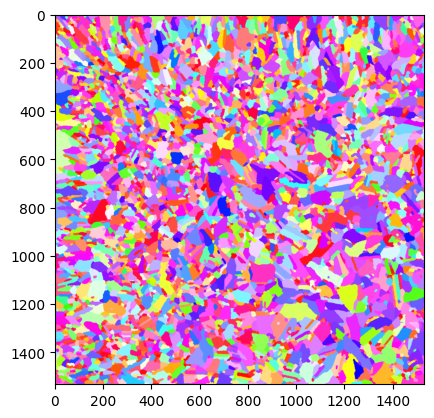

In [148]:
thresh = 50
df = pd.read_csv("results_for_articles/df_median.csv")
df_small = df.copy()

# paint black for small grains that means area under 50
df_count = df.groupby("Grain ID").size().reset_index(name = "count").copy()
small_grains_ID = df_count[df_count["count"] <= thresh]["Grain ID"].values
for id in small_grains_ID:
    df_small.loc[df_small["Grain ID"] == id, "Grain ID"] = -1

condition = df_small["Grain ID"] == -1
df_small.loc[condition, 'q1'] = 0.2
df_small.loc[condition, 'q2'] = 1
df_small.loc[condition, 'q3'] = 1
df_small.loc[condition, 'q4'] = 1

df_small.to_csv("results_for_articles/df_median_small_deleted.csv")

selected_columns = ['q1', 'q2','q3','q4']
q_numpy_mean = df_small[selected_columns].values
q_numpy_mean = q_numpy_mean.reshape(1533,1533,4)

rot_mean = R.from_quat(q_numpy_mean.reshape(-1,4))
img_ND_mean = get_RGB(stereographic2sst(rot_mean.apply([0,0,1]))).reshape(1533,1533,3)

img_ND_grain = img_ND_mean.copy()
h, w, c = img_ND_grain.shape
idx = 0
for height in range(0, h):
    for width in range(0, w):
        if df_small['Grain ID'][idx] == -1:
            img_ND_grain[height][width] = [0, 0, 0]
        idx += 1  

img_blacked_filled = randomly_fill_target_color_in_image(img_ND_grain, (0,0,0))
fig, ax = plt.subplots()
ax.imshow(img_blacked_filled);
io.imsave("results_for_articles/crystal_grain_enlarging.tif", img_as_ubyte(img_blacked_filled))

##### For details of StyleGAN2-ADA, please refer to https://github.com/NVlabs/stylegan2-ada-pytorch.
##### For details of pix2pix, please refer to https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix